# Imports

In [1]:
#basic data analysis
import numpy as np
import pandas as pd

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#for Chi-Square
import scipy.stats as stats

#data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

#tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# Clean Dataset

In [2]:
#import the dataset
student_health = pd.read_csv("C:/Users/barbe/OneDrive/URI DS Program/577 Data Enabled Capstone/student_health_data.csv")

# drop student id
student_health = student_health.drop(columns=["Student_ID"])

#convert object variables to categorical variables
for col in student_health.select_dtypes(include = ['object']).columns:
    student_health[col] = student_health[col].astype('category')

In [ ]:
#remove outliers

#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in numerical_var:
    outliers = identify_outliers(student_health, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

#get outlier indices
outlier_indices = outliers_df.index

#drop rows in dataset with outlier indices
cleaned_df = student_health.drop(outlier_indices)

# Getting Ready to Model

#### Split the data

First we separate the our features and target variable into a feature matrix and a target vector.

In [25]:
#define feature matrix and target vector
X = cleaned_df.drop(columns = ["Health_Risk_Level"])
y = cleaned_df["Health_Risk_Level"]

In [26]:
#check sizes
print(f'cleaned_df size: {cleaned_df.shape}')
print(f'feature matrix size: {X.shape}')
print(f'target vector size: {y.shape}')

cleaned_df size: (979, 13)
feature matrix size: (979, 12)
target vector size: (979,)


In [27]:
X.head()

,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours
0,24,M,50.663217,122.173015,84.419860,3.137350,9.028669,High,Moderate,Happy,34.520973,16.800956
1,21,F,57.926042,110.778407,75.696145,3.699078,5.819697,Moderate,Good,Stressed,16.763846,15.791154
2,22,M,59.294219,109.375673,83.803814,6.785156,5.892360,Low,Moderate,Happy,44.203798,25.678437
3,24,M,76.826232,125.142227,78.091587,6.408509,6.884001,High,Poor,Happy,21.776645,20.808391
4,20,M,68.342769,107.515592,80.674937,7.264719,4.483450,Moderate,Poor,Happy,8.964999,15.194045


Next step is to split the data into a training set (80%), and validation set for hyperparameter tuning (10%) and a test set for a final model performance (10%). Since we have class imbalance in the target variable, we want to make sure that each target split contains the same distribution of classes.

In [28]:
#split data into a training set and a temp set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

#split the temp set into a validation set and final test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 12)

Now to ensure that that the split occurred as desired. First we check the sizes of our feature sets

In [29]:
#check number of instances in each split
print(f"Training set size: {X_train.shape[0]}") #X_train.shape[0] gives the number of rows in the trainin set
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 783
Validation set size: 98
Test set size: 98


In [30]:
print(783/979)
print(98/979)

0.7997957099080695
0.10010214504596528


Next, we ensure that each target variable has the same distribution.

In [31]:
#print class distribution as percent
print("Class distribution in Training Set:") #training set
print(y_train.value_counts(normalize=True))  #normalized (percentages)

print("\nClass distribution in Validation Set:") #validation set
print(y_val.value_counts(normalize=True))

print("\nClass distribution in Test Set:") #test set
print(y_test.value_counts(normalize=True))

Class distribution in Training Set:
Health_Risk_Level
Moderate    0.670498
Low         0.190294
High        0.139208
Name: proportion, dtype: float64

Class distribution in Validation Set:
Health_Risk_Level
Moderate    0.663265
Low         0.193878
High        0.142857
Name: proportion, dtype: float64

Class distribution in Test Set:
Health_Risk_Level
Moderate    0.673469
Low         0.183673
High        0.142857
Name: proportion, dtype: float64


It looks like the data has been split relatively evenly, retaining the distribution of categories quite well.

#### Preprocess the data

Now that the data has been split, let's go ahead and preprocess it. We begin by encoding the categorical data, then scaling using a standard scaler.
- It should be noted that tree-based models don't require as much preprocessing, but to ensure consistency across different models (tree-based, KNN, SVM), it's simpler to preprocess the data once and use the preprocessed data for all models.
- LabelEncoder converts each category into a unique integer. This is preferred for the target variable.
- pd.get_dummies is used for one-hot encoding. This is preferred for categorical features.
- Aligning ensures all datasets have the same features.

In [32]:
#encode categorical features - uses one-hot encoding
#allows the models to interpret each category as a distinct entity - preferred for KNN and SVM
X_train_encode = pd.get_dummies(X_train)
X_val_encode = pd.get_dummies(X_val)
X_test_encode = pd.get_dummies(X_test)

#align validation and test sets with training set - ensures same columns
X_val_encode = X_val_encode.reindex(columns = X_train_encode.columns, fill_value = 0)
X_test_encode = X_test_encode.reindex(columns = X_train_encode.columns, fill_value = 0)

#initialize and fit scaler on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode)

#transform validation and test data
X_val_scaled = scaler.transform(X_val_encode)
X_test_scaled = scaler.transform(X_test_encode)

#manually set class order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["Low", "Moderate", "High"])  #custom order

#encode labels - this method is preferrred for target as it assigns a unique integer to each class
y_train_encode = label_encoder.transform(y_train)
y_val_encode = label_encoder.transform(y_val)
y_test_encode = label_encoder.transform(y_test)

#check mapping
label_mapping = dict(enumerate(label_encoder.classes_))
print("Label Encoding Mapping:", label_mapping)

#rename matrices and vectors for ease of use - could  be done better, but didn't want to overwrite previous train, val, and test
X_train2 = X_train_scaled
X_val2 = X_val_scaled
X_test2 = X_test_scaled

y_train2 = y_train_encode
y_val2 = y_val_encode
y_test2 = y_test_encode

Label Encoding Mapping: {0: 'Low', 1: 'Moderate', 2: 'High'}


Now that we have our data preprocess, it's time to begin the modeling process.

# Tree-Based Models

## Decision Tree

### Initializing and Training the Decision Tree

Let's sart with a default decision tree.

In [33]:
#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#train the model
dt.fit(X_train2, y_train2)

#make predictions on validation set
y_pred = dt.predict(X_val2)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree Validation Accuracy: 0.97
Decision Tree Weighted F1-Score: 0.97
Decision Tree Weighted Precision: 0.97
Decision Tree Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12


In [34]:
#perform cross-validation
cv_scores = cross_val_score(dt, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 0.99 (+/- 0.01)


Here is what our metrics tell us:
- We have a 97% overall accuracy, meaning the model performs well in correctly classifying instances.
- The F1-Score is quite high, indicating a balance between precision and recall.
- High precision indicates that when our model predicts a class, it's likely to be correct.
- A high recall suggests that our model is effectively capturing most of the actual instances.
- The F1-Score, Precision, and Recall being 97% indicates that the model maintains a good balance between precision and recall across different classes.
- There were no misclassifications for Low risk levels, which means the model is confident and accurate predicting this class.
- Note that 2 High health risk levels were predicted as Moderate and 1 Moderate instance was classified as High. This may be because the model finds it harder to distinguish between Moderate and High risk levels - especially if the boundary between these two classes are less clear compared to Low and the other two.
- If predicting High-Risk as Moderate means missing out on critical intervention actions, this could be potentially dangerous since the instance wouldn't receive the care they require. This also depends on the care received for Moderate and High.
    - If high risk cases receive significantly different care than moderate, even a small misclassification rate could have serious consequences. A recall-focused approach might be beneficial.
 
Cross-Validation score:
- A mean accuracy of 99% indicates that the model consistently performs well across the different folds. This suggests that the model generalizes well to unseen data isn't overfitting to the training data.
- The low standard deviation indicates that the performance of the model is stable and consistent across the different folds. This means that the model's performance doesn't vary much with different subsets of the data.

#### Initial Visualization of the Decsion Tree

Let's take a look at the model, and take a look at feature importance.

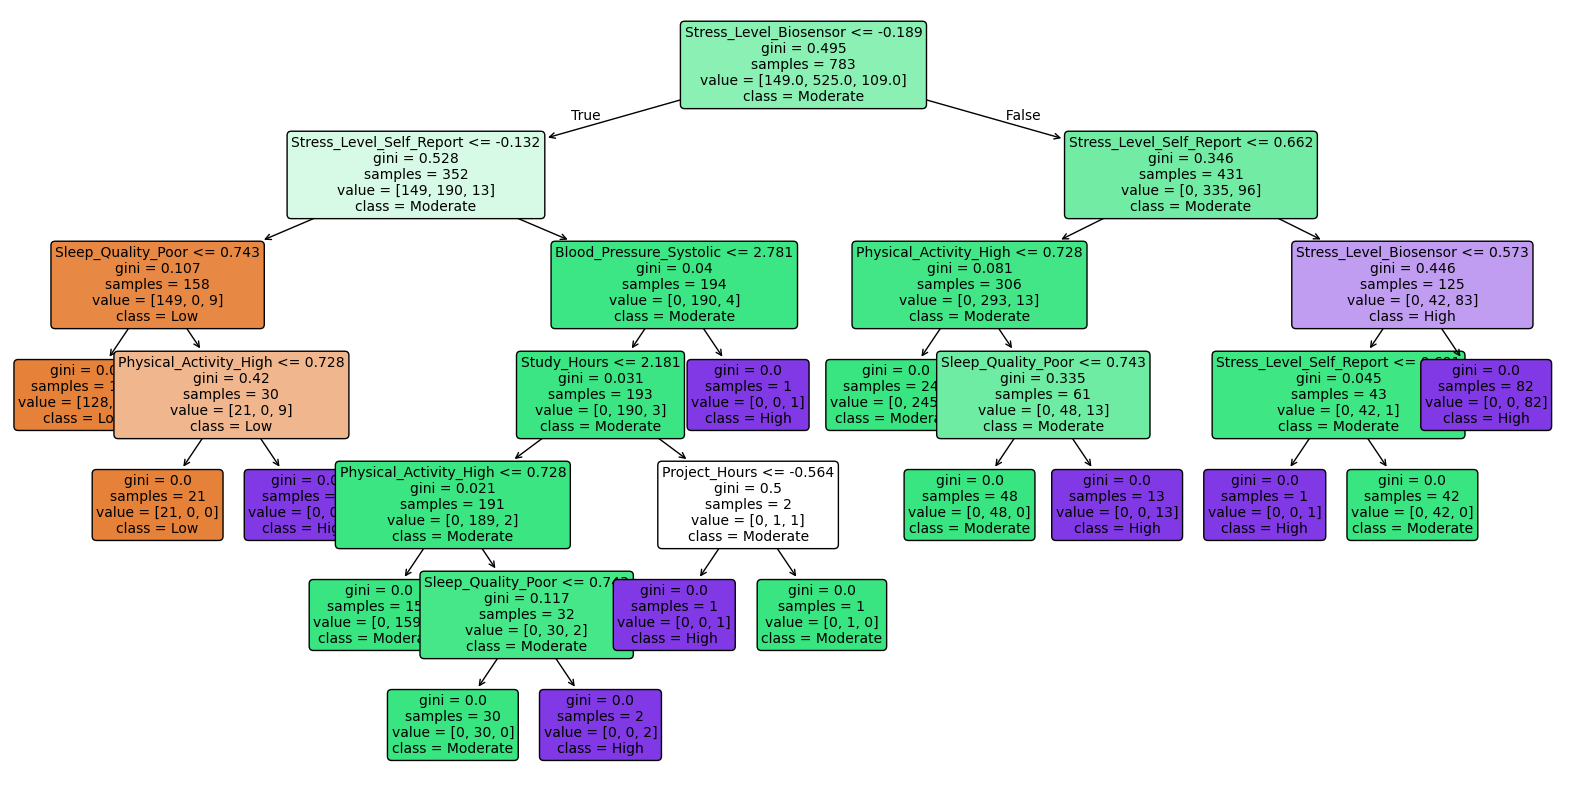

In [35]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt, 
          feature_names=X_train_encode.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

Note: The small tree makes it relatively easy to follow.
- Stress levels seem to be the most important feature in predicting health risk levels.
- Poor sleep quality, blood pressure, and high physical activity seems to be the next important features.
- We also see study hours and project hours play a role.
- With a low depth, the tree has enough complexity to capture the nuances in the data without overfitting.
- The leaf nodes indicate the final classification for different combinations of features, providing clear decision paths.

#### Initial Decision Tree Structure Format

Looking at the tree structure can help determine which hyperparameters to tune and around which values to use.

In [36]:
print("Depth of the decision tree: ", dt.tree_.max_depth)#depth of tree
print("Number of nodes: ", dt.tree_.node_count) #number of nodes
print("Number of splits: ", dt.tree_.n_leaves) #number of splits

Depth of the decision tree:  6
Number of nodes:  29
Number of splits:  15


#### Initial Decision Tree Feature Importance

In [37]:
#get feature importanc scores
feature_importance = dt.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt = importance_dt.sort_values(by='Importance', ascending=False)

#display top features
print(importance_dt.head(8))

                     Feature  Importance
5   Stress_Level_Self_Report    0.597734
4     Stress_Level_Biosensor    0.273982
15        Sleep_Quality_Poor    0.073772
10    Physical_Activity_High    0.044506
2    Blood_Pressure_Systolic    0.004977
7              Project_Hours    0.002581
6                Study_Hours    0.002448
0                        Age    0.000000


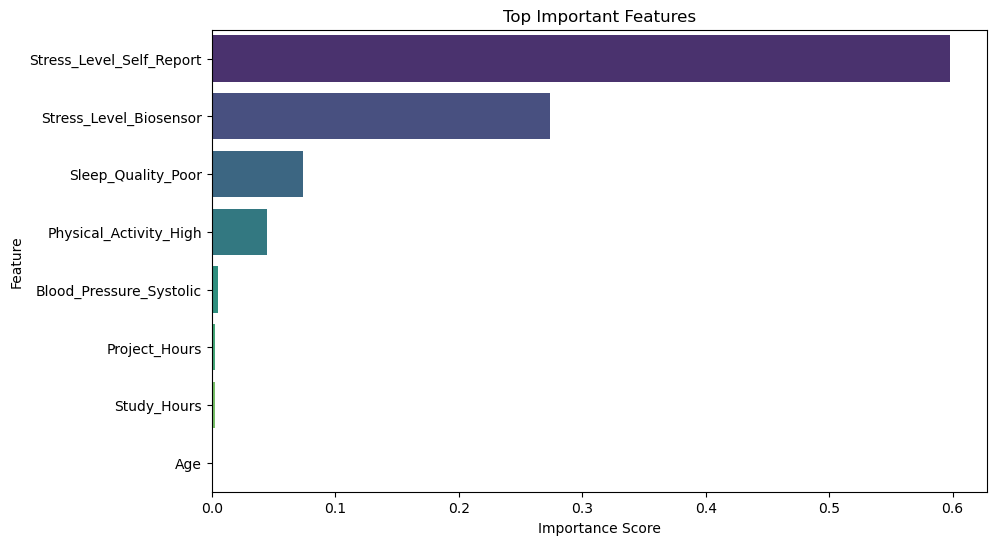

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_dt[:8], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

Observations from the output:
- Stress levels are the most significant features.
- Poor sleep quality and high physical activity are also shown to have some significance.
- Systolic blood pressure and project/study hours have minimal significance.
- All other features are deemed to have no importance.

Interpretations:
- Stress levels dominate predictions. This suggests interventions targeting stress reduction could significantly improve student health.
- Sleep quality matters, but noticing that Sleep_Quality_Good doesn't contribute to predictions implies that improving poor sleep quality could also prove helpful in reducing risk levels.
- Physical_Activity_High has some relevance, while Studey_Hours and Project_Hours have very little. This may indicate that mental and physical well-being are more indicative of health risk than academic load.
  - Note that academic load, along with physical activities, could play a significant role in stress levels.

### Improving the Decision Tree

Now that we have out first tree, let's try to optimize it using grid search.
- GridSearchCV will help determine the optmial combination of hyperparameters by testing all possible combinations of values defined in a grid.
- Since the initial tree had a max depth of 6, we'll try a range around that value to see if a slightly more shallow or deeper tree performs better.
- We'll tune min_samples_split and min_samples_leaf to control the number of splits and leaves
- We'll also check criterion for splitting.

#### Grid Search CV for Decision Tree

In [39]:
#define parameter grid
params = {
    'max_depth': [4, 6, 8, 10], #max depth of tree
    'min_samples_split': [2, 5, 10, 20], #values to control the number of splits
    'min_samples_leaf': [1, 5, 10, 20], #values to control minimum samples per leaf node
    'criterion': ['gini', 'entropy'] #different splitting criteria
}

In [40]:
#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#initialize grid search
grid_search = GridSearchCV(estimator = dt, param_grid = params, cv = 10, scoring = 'f1_weighted')

In [42]:
#fit grid search to training data and record time
grid_search.fit(X_train2, y_train2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=13),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_weighted')

In [43]:
#get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Training and Evaluating Tuned Decision Tree

In [44]:
#initialize model with best parameters
dt_tune = DecisionTreeClassifier(
    random_state=13,
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split']
)

#train the model
dt_tune.fit(X_train2, y_train2)

#make predictions on validation set
y_pred = dt_tune.predict(X_val2)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree (Tuned) Validation Accuracy: 0.97
Decision Tree (Tuned) Weighted F1-Score: 0.97
Decision Tree (Tuned) Weighted Precision: 0.97
Decision Tree (Tuned) Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12


In [45]:
#perform cross-validation
cv_scores = cross_val_score(dt_tune, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 1.00 (+/- 0.01)


No clear differences in evaluation metrics. Even the misclassifications are the same. Also note that the cross-validation accuracy has increased.

#### Visualization of Tuned Decision Tree

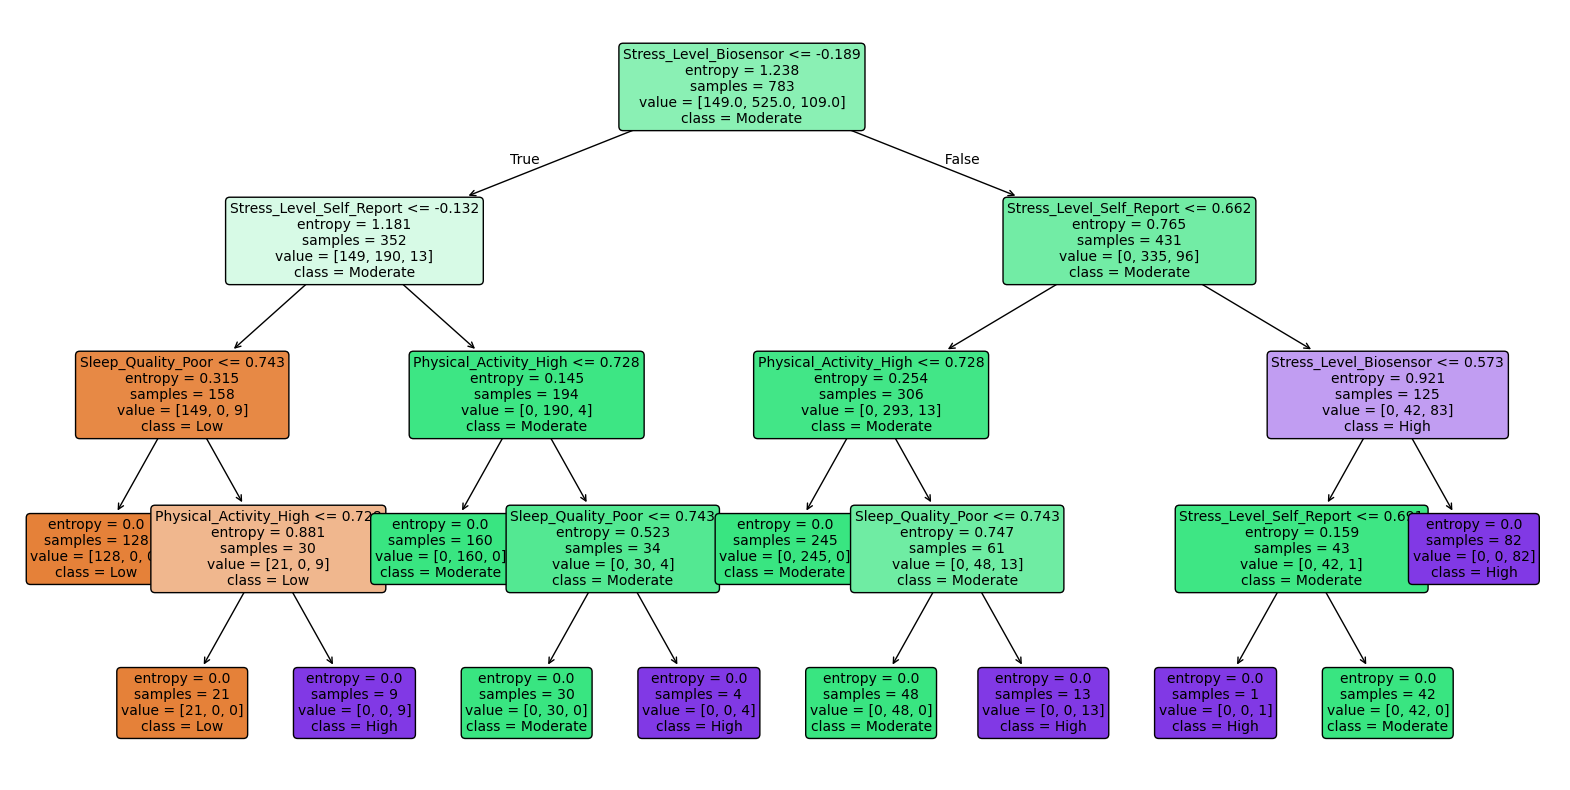

In [46]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt_tune, 
          feature_names=X_train_encode.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

This tree looks less complex than what we got with our default decision tree. We can see that stress, poor sleep quality, and high physical activity are still the most important features.

#### Tuned Decision Tree Structure Format

In [47]:
print("Depth of the decision tree: ", dt_tune.tree_.max_depth)#depth of tree
print("Number of nodes: ", dt_tune.tree_.node_count) #number of nodes
print("Number of splits: ", dt_tune.tree_.n_leaves) #number of splits

Depth of the decision tree:  4
Number of nodes:  23
Number of splits:  12


#### Tuned Decision Tree Feature Importance

In [48]:
#get feature importanc scores
feature_importance = dt_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt_tune = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt_tune = importance_dt_tune.sort_values(by='Importance', ascending=False)

#display top features
importance_dt_tune.head(8)

,Feature,Importance
5,Stress_Level_Self_Report,0.496835
4,Stress_Level_Biosensor,0.342758
15,Sleep_Quality_Poor,0.089460
10,Physical_Activity_High,0.070946
0,Age,0.000000
11,Physical_Activity_Low,0.000000
17,Mood_Neutral,0.000000
16,Mood_Happy,0.000000


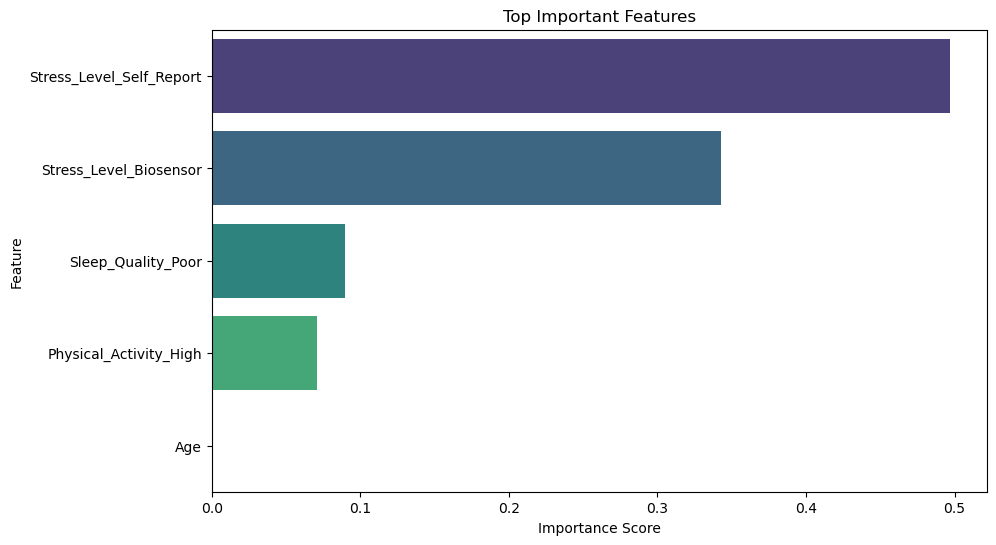

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_dt_tune[:5], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

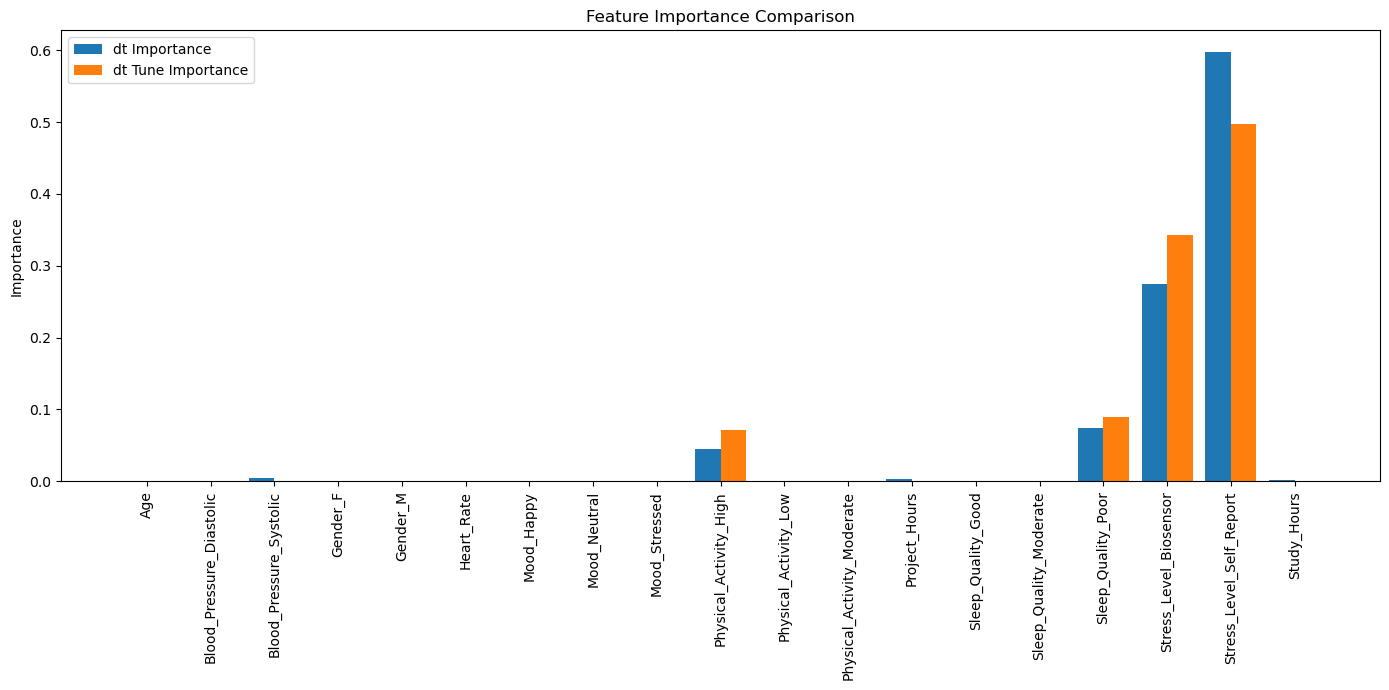

In [50]:
#ensure feature columns are same in both importance dataframes 
importance_dt = importance_dt.sort_values(by='Feature').reset_index(drop=True)
importance_dt_tune = importance_dt_tune.sort_values(by='Feature').reset_index(drop=True)

#merge dataframes on feature column
df_compare = pd.merge(importance_dt, importance_dt_tune, on='Feature', suffixes=('_dt', '_dt_tune'))

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.4  # width of the bars

#plot importance for initial decision tree
ax.bar(df_compare.index - width / 2, df_compare['Importance_dt'], width, label='dt Importance')

#plot importance for tuned decision tree
ax.bar(df_compare.index + width / 2, df_compare['Importance_dt_tune'], width, label='dt Tune Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Comparison')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

Feature importance is between the tuned decision tree and the initial decision tree are very similar. 
- We see that stress, poor sleep quality, and high physical activities still play an integral role.
- Blood_Pressure_Systolic, Study_Hours and Project_Hours no longer have any significance. They had minimal significance before.

Interpretation is same as before:
- Interventions targeting stress reduction could significantly improve student health.
- Improving poor sleep quality could prove helpful in reducing risk levels.
- Physical activity has an impact on health risk levels.

#### Tuned DT Final Test

The very last step is to see how this model performs with unseen data.

In [51]:
#make predictions on test set
y_pred = dt_tune.predict(X_test2)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree (Tuned) Test Accuracy: 1.00
Decision Tree (Tuned) Weighted F1-Score: 1.00
Decision Tree (Tuned) Weighted Precision: 1.00
Decision Tree (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


The model perform exceptionally well on it's final test. 

## Random Forest

### Initial Random Forest

Now that we've checked out a decision tree, let's see what random forest can produce.

In [52]:
#initialize random forest
rf = RandomForestClassifier(random_state=13)

#train the model
rf.fit(X_train2, y_train2)

#make predictions on validation set
y_val_pred_rf = rf.predict(X_val2)

#evaluate random forest
rf_acc = accuracy_score(y_val2, y_val_pred_rf)
rf_f1 = f1_score(y_val2, y_val_pred_rf, average='weighted')
rf_precision = precision_score(y_val2, y_val_pred_rf, average='weighted')
rf_recall = recall_score(y_val2, y_val_pred_rf, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_val_pred_rf, rownames = ['Actual'], colnames = ['Predicted'])

#print metrics
print(f'Random Forest Validation Accuracy: {rf_acc:.2f}')
print(f'Random Forest Weighted F1-Score: {rf_f1:.2f}')
print(f'Random Forest Weighted Precision: {rf_precision:.2f}')
print(f'Random Forest Weighted Recall: {rf_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest Validation Accuracy: 0.98
Random Forest Weighted F1-Score: 0.98
Random Forest Weighted Precision: 0.98
Random Forest Weighted Recall: 0.98
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   2  12


In [53]:
#perform cross-validation
cv_scores = cross_val_score(rf, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 0.97 (+/- 0.03)


Our initial Random Forest performed slightly better than our tuned Decision Tree.
- Only two instances were miclassified: 2 High instances were classified as Moderate.
- Overall, the performance metrics and confusion matrix indicates that the Random forest Model is performing very well, with minimal misclassifications.
- Interpretations of the metrics follow that from the Decision Tree.

Cross-Validation score:
- The CV score is 97%, indicating that this model does consistently perform well across different folds, though this score is slightly lower than what we saw with the decision tree. Regardless, the model generalizes well.
- The standard deviation is quite low, indicating that the model's performance is stable and consistent across the folds. With that said, it is slightly higher than what we saw in the decision tree.

#### Default RF Feature Importance

In [54]:
#get feature importanc scores
feature_importance = rf.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

#display top features
print(importance_rf)

                       Feature  Importance
5     Stress_Level_Self_Report    0.322402
4       Stress_Level_Biosensor    0.304073
3     Blood_Pressure_Diastolic    0.047011
7                Project_Hours    0.044112
1                   Heart_Rate    0.043449
2      Blood_Pressure_Systolic    0.043027
6                  Study_Hours    0.043024
10      Physical_Activity_High    0.032902
15          Sleep_Quality_Poor    0.029979
0                          Age    0.024332
12  Physical_Activity_Moderate    0.010230
16                  Mood_Happy    0.009064
11       Physical_Activity_Low    0.008071
14      Sleep_Quality_Moderate    0.007520
13          Sleep_Quality_Good    0.007221
17                Mood_Neutral    0.006994
18               Mood_Stressed    0.005967
8                     Gender_F    0.005873
9                     Gender_M    0.004749


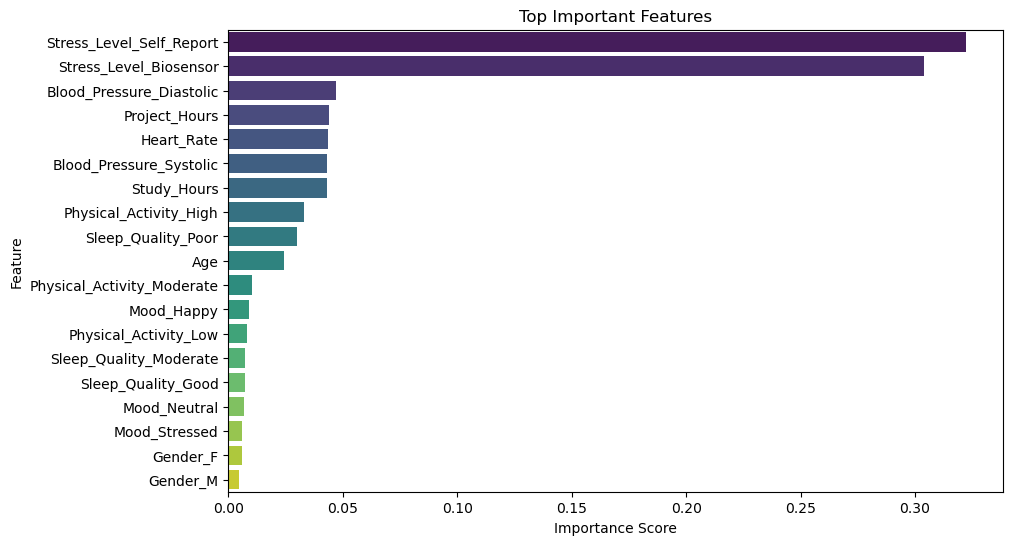

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf[:20], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

Feature Importance shares in similarities and distinct differences than from the decision tree.
- Stress levels are still the most important features. Combined they account for over 62% of the total feature importance.
- Blood pressure, heart rate, and project/study hours are also quite significant, accounting for over 22% of feature importance.
- High physical activity, poor sleep quality, and age also have noticeable feature importance.
- The remaining features have very low impact.

Interpretation:
- Stress levels are the most significant predictors of health risk levels. This makes sense as high stress is a known risk factor for various health issues. Interventions and techniques targeting stress reduction could significantly improve student health.
- Blood pressure and heart rate have similar contributions. These physiological metrics are likely correlated with stress and health risks. This model is capturing the physiological effects of stress, where increased stress levels may correlate with changes in heart rate and blood pressure.
- Study and project hours also play an important part. Higher study/project hours may contribute to higher stress levels, which aligns with stress being the top predictor. Additionally, students with poor health may have lower study hours due to their condition.
- High physical activity is most important among activity levels, indicating that high physical activity is associated with lower or higher health risks.
- Poor sleep quality has a noticeable impact, which suggesrs that poor sleep is linked to higher health risks.
- Age also has a noticeable impact, if only a little.
- Pooling together, we can see that academic load, high phyisical activities, and poor sleep quality may play an important role in stress levels.
- While other features do also play some role in predicting health risk levels, they contribute 1% or less, making them negligble.

### Tuning the Random Forest Classifier

Utilizing GridSearchCV, let's see if we can tune some of the hyperparameters and enhance our model.

In [56]:
#define parameter grid
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

#initialize random forest
rf = RandomForestClassifier(random_state = 56)

#initialize grid search
grid_search = GridSearchCV(estimator = rf, param_grid = params, cv=10, n_jobs=-1, verbose=2, scoring = 'f1_weighted')

In [58]:
#fit the grid search
grid_search.fit(X_train2, y_train2)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=56),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_weighted', verbose=2)

In [59]:
#get best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


#### Training and Evaluating Tuned RF

In [60]:
#get best model from grid search
rf_tune = grid_search.best_estimator_

#train the tuned model
rf_tune.fit(X_train2, y_train2)

#make predictions
y_pred = rf_tune.predict(X_val2)

#evaluate model 
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest (Tuned) Validation Accuracy: 0.99
Random Forest (Tuned) Weighted F1-Score: 0.99
Random Forest (Tuned) Weighted Precision: 0.99
Random Forest (Tuned) Weighted Recall: 0.99
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   1  13


In [61]:
#perform cross-validation
cv_scores = cross_val_score(rf_tune, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 0.98 (+/- 0.02)


As we can see, our tuned model performed slightly better than our initial model.
- Accuracy, weighted F1, precision, and recall are now at 99%.
- One High instance was misclassified as Moderate. No other misclassifications.

Cross-Validation
- The mean accuracy has increased to 98%, while the standard deviation decreased to 0.02. This indicates that the tuned model is performing slightly better than the initial model.

#### Tuned RF Feature Importance

In [62]:
#get feature importanc scores
feature_importance = rf_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf_tune = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf_tune = importance_rf_tune.sort_values(by='Importance', ascending=False)

#display top features
print(importance_rf_tune)

                       Feature  Importance
5     Stress_Level_Self_Report    0.338799
4       Stress_Level_Biosensor    0.337066
10      Physical_Activity_High    0.040104
15          Sleep_Quality_Poor    0.038522
6                  Study_Hours    0.035950
1                   Heart_Rate    0.034515
2      Blood_Pressure_Systolic    0.033111
7                Project_Hours    0.032728
3     Blood_Pressure_Diastolic    0.031328
0                          Age    0.018437
12  Physical_Activity_Moderate    0.010616
13          Sleep_Quality_Good    0.010542
11       Physical_Activity_Low    0.009212
14      Sleep_Quality_Moderate    0.008623
17                Mood_Neutral    0.004667
16                  Mood_Happy    0.004491
8                     Gender_F    0.004088
9                     Gender_M    0.003752
18               Mood_Stressed    0.003449


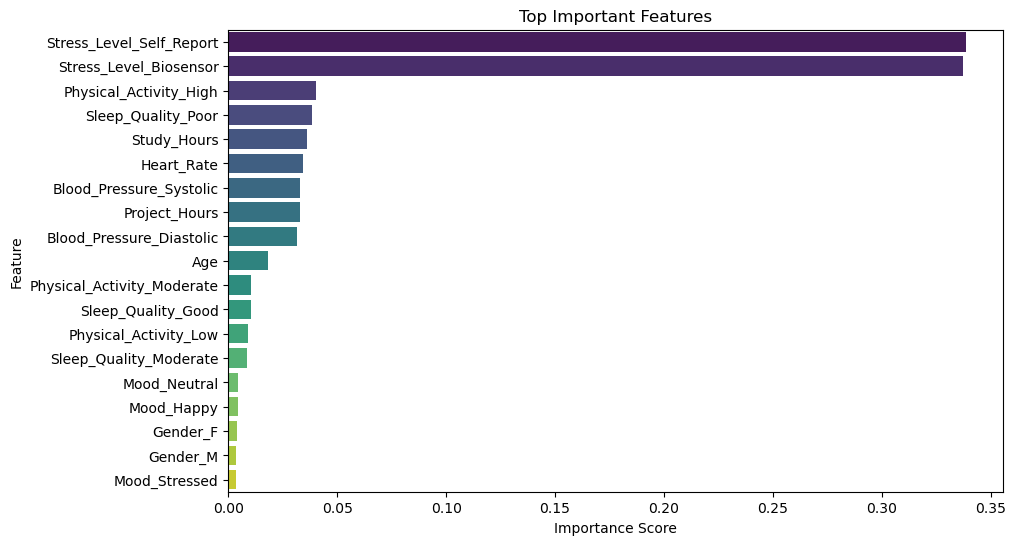

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf_tune[:20], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

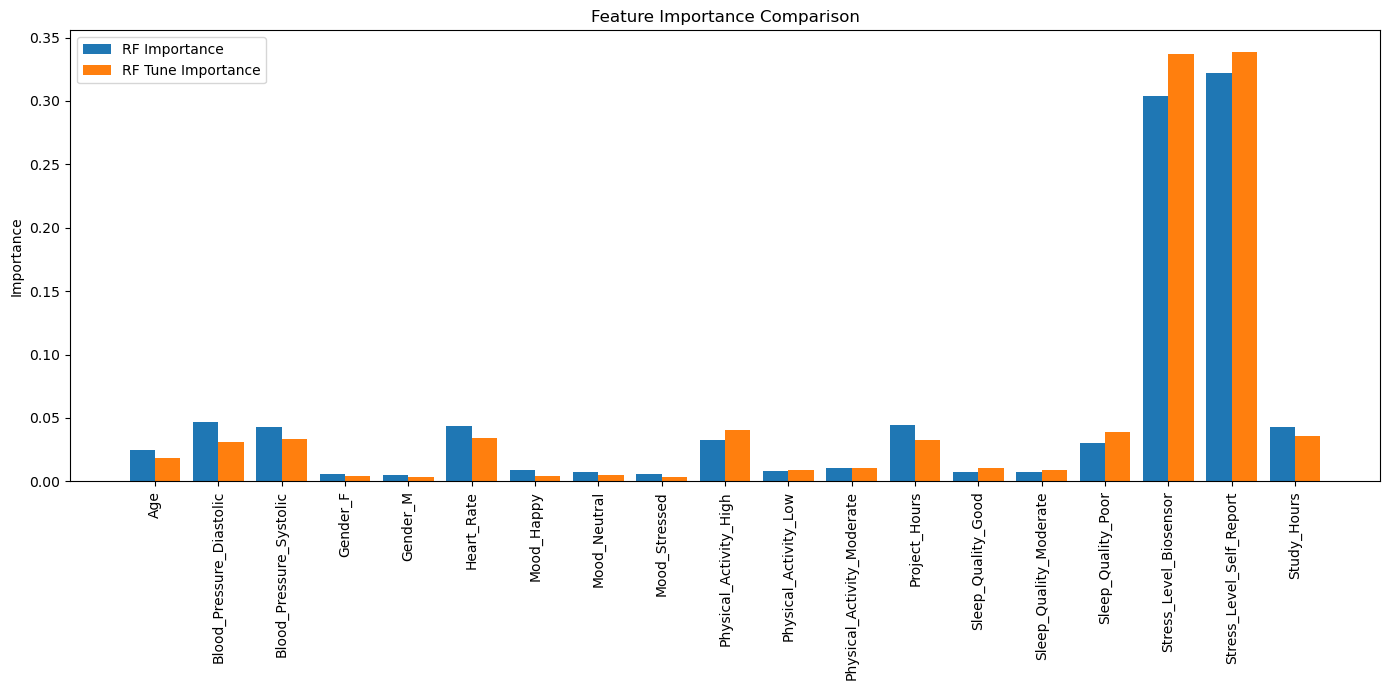

In [64]:
#ensure feature columns are same in both importance dataframes 
importance_rf = importance_rf.sort_values(by='Feature').reset_index(drop=True)
importance_rf_tune = importance_rf_tune.sort_values(by='Feature').reset_index(drop=True)

#merge dataframes on feature column
df_compare = pd.merge(importance_rf, importance_rf_tune, on='Feature', suffixes=('_rf', '_rf_tune'))

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.4  #width of the bars

#plot importance for initial model
ax.bar(df_compare.index - width / 2, df_compare['Importance_rf'], width, label='RF Importance')

#plot importance for tuned model
ax.bar(df_compare.index + width / 2, df_compare['Importance_rf_tune'], width, label='RF Tune Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Comparison')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

Only a slight change in feature importance in the tuned random forest compared to the initial random forest.
- Stress is still higlighted as the most important feature.
- Blood pressure, heart rate, high physical activity, poor sleep quality, and study/project hours are still significant.
    - Notice that stress, high physical activity, and poor sleep increased in importance in our tuned model.
    - We can see this in a couple of other features, but their overall importance is negligible

#### Tuned RF Final Test

Last part os the check how this model does with unseen data.

In [65]:
#make predictions on test set
y_pred = rf_tune.predict(X_test2)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest (Tuned) Test Accuracy: 1.00
Random Forest (Tuned) Weighted F1-Score: 1.00
Random Forest (Tuned) Weighted Precision: 1.00
Random Forest (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


As with the tuned decision tree, this model did great on unseen data.

## XGBoost

#### Initial XGB Model

In [66]:
#initialize xgboost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=13)

#train the model
xgb.fit(X_train2, y_train2)

#make predictions on validation set
y_pred = xgb.predict(X_val2)

#evaluate XGBoost
xgb_acc = accuracy_score(y_val2, y_pred)
xgb_f1 = f1_score(y_val2, y_pred, average='weighted')
xgb_precision = precision_score(y_val2, y_pred, average='weighted')
xgb_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   0  14


In [67]:
#perform cross-validation
cv_scores = cross_val_score(xgb, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 1.00 (+/- 0.01)


Right away, this model proves to be very successful in predicting health risk levels. Even the CV accusracy is quite high and the CV standard deviation is quite low.

#### XGBost Feature Importance

In [68]:
#get feature importanc scores
feature_importance = xgb.feature_importances_

#create dataframe to visualize feature importance scores
importance_xgb = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)

#display top features
print(importance_xgb)

                       Feature  Importance
5     Stress_Level_Self_Report    0.401123
4       Stress_Level_Biosensor    0.319384
15          Sleep_Quality_Poor    0.141437
10      Physical_Activity_High    0.099521
6                  Study_Hours    0.012987
2      Blood_Pressure_Systolic    0.008283
12  Physical_Activity_Moderate    0.004191
1                   Heart_Rate    0.003148
13          Sleep_Quality_Good    0.002623
0                          Age    0.002099
7                Project_Hours    0.001914
14      Sleep_Quality_Moderate    0.001044
3     Blood_Pressure_Diastolic    0.000882
17                Mood_Neutral    0.000691
16                  Mood_Happy    0.000673
9                     Gender_M    0.000000
11       Physical_Activity_Low    0.000000
8                     Gender_F    0.000000
18               Mood_Stressed    0.000000


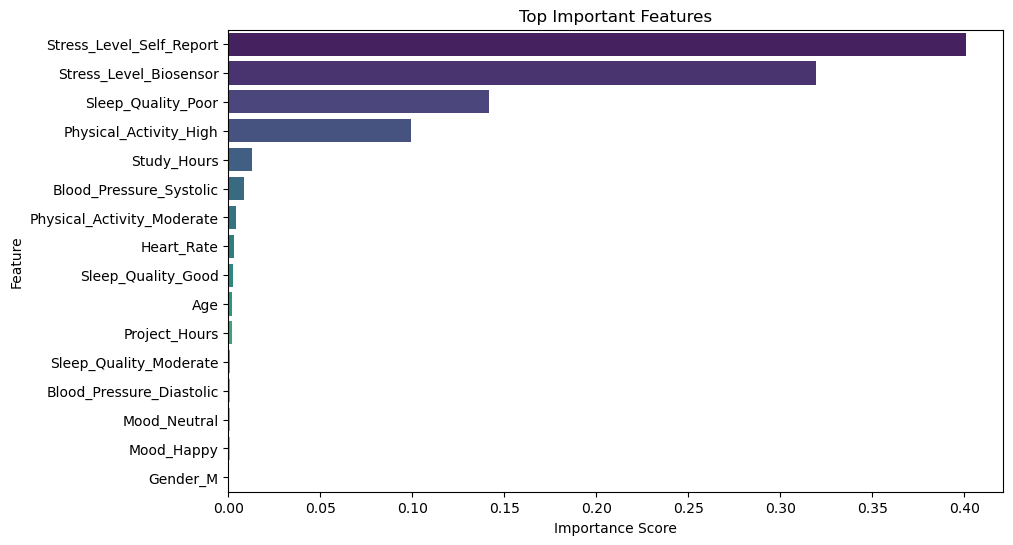

In [69]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_xgb['Importance'][:16], y=importance_xgb['Feature'][:16], hue=importance_xgb['Feature'][:16], 
            palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

Feature importance follows similarly to that of our previous tree models.
- Stress retains the status as most important.
- Poor sleep quality and high physical activity are the next most important.
- All other features only hold 1% or less of importance each.

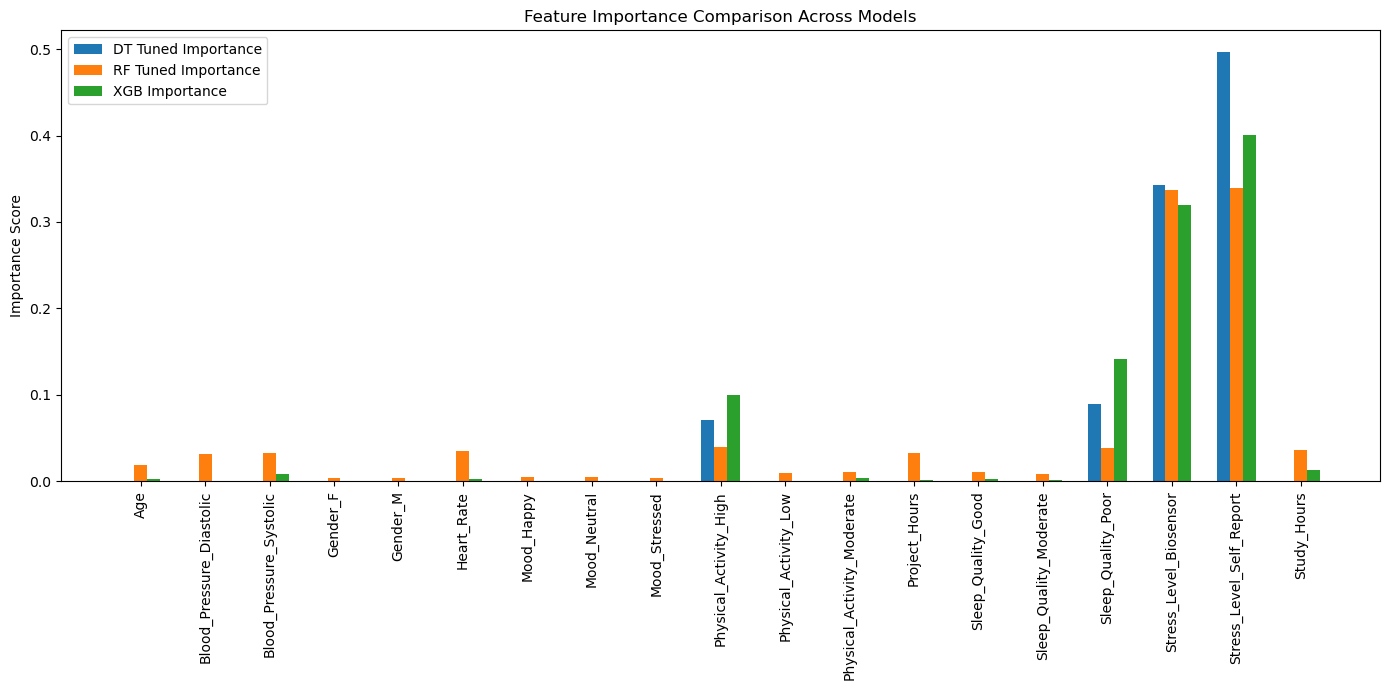

In [70]:
#ensure feature columns are the same
importance_dt_tune = importance_dt_tune.sort_values(by='Feature').reset_index(drop=True)
importance_rf_tune = importance_rf_tune.sort_values(by='Feature').reset_index(drop=True)
importance_xgb = importance_xgb.sort_values(by='Feature').reset_index(drop=True)

#merge on feature column
df_compare = importance_dt_tune.merge(importance_rf_tune, on='Feature', suffixes=('_dt_tune', '_rf_tune'))
df_compare = df_compare.merge(importance_xgb, on='Feature')
df_compare.rename(columns={'Importance': 'Importance_xgb'}, inplace=True)

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.2  #width of the bars

#plot importance for Tuned Decision Tree
ax.bar(df_compare.index - width, df_compare['Importance_dt_tune'], width, label='DT Tuned Importance')

#plot importance for Tuned Random Forest
ax.bar(df_compare.index, df_compare['Importance_rf_tune'], width, label='RF Tuned Importance')

# plot importance for XGBoost
ax.bar(df_compare.index + width, df_compare['Importance_xgb'], width, label='XGB Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance Score')
ax.set_title('Feature Importance Comparison Across Models')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

Here, we can see the feature importance from the tunned decisiont tree, the tuned random forest, and the xgb model.
- All three models indicate that the most important features are stress levels, poor sleep quality, and high physical activity.
- Other notable features are study/project hours, heart rate, and blood pressure.
- Age is also something to consider, but all other features are seemingly unimportant.

#### XGBoost Final Test

In [71]:
#make predictions on validation set
y_pred = xgb.predict(X_test2)

#evaluate XGBoost
xgb_acc = accuracy_score(y_test2, y_pred)
xgb_f1 = f1_score(y_test2, y_pred, average='weighted')
xgb_precision = precision_score(y_test2, y_pred, average='weighted')
xgb_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


As expected, the xgb model performed excellently on unseen data.

# Further Tree-Based Modeling Exploration

Throughout this process, feature importance has been checked regularly. In each of the models, the same four features have shown to be the most important:
- Stress_Level_Self_Report, Stress_Level_Biosensor, Sleep_Quality_Poor, and Physical_Activity_High.

Other features have also shown some level of importance depending on the model.
- Decision Tree only gave the above four importance.
- Random Forest additionally gave blood pressure, heart rate, and study/project hours. Age also got some importance, but below 2%. Other features got minimal importance.
- The xgb model also gave additional importance to other features, but these came in at 1% or less.

To further investigate feature importance and how it impacts the tree-based models, A sub-dataset will be used containing only the four most relevant features. Aside from decreasing the number of features, everything else will be ran the same. In all likelyhood, this is expected to have minimal impact on the previous scores, if any.

***Note***: the data has been preprocessed already. All that needs to be done is to select the important features.

## Creating the subset

In [72]:
#define important features
important_features = ['Stress_Level_Self_Report', 'Stress_Level_Biosensor', 'Sleep_Quality_Poor', 'Physical_Activity_High']

#create subsets from encoded feature matrices
X_train_subset = X_train_encode[important_features]
X_val_subset = X_val_encode[important_features]
X_test_subset = X_test_encode[important_features]

#scale subsets
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_val_subset_scaled = scaler.transform(X_val_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)

#check the shapes
print(X_train_subset_scaled.shape, X_val_subset_scaled.shape, X_test_subset_scaled.shape)

#rename for ease of use
X_train3 = X_train_subset_scaled
X_val3 = X_val_subset_scaled
X_test3 = X_test_subset_scaled

(783, 4) (98, 4) (98, 4)


Now that we have our subsets, let's go through our models.

## Decision Tree

### Initial DT

In [73]:
#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#train the model
dt.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = dt.predict(X_val3)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(dt, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Decision Tree Validation Accuracy: 0.97
Decision Tree Weighted F1-Score: 0.97
Decision Tree Weighted Precision: 0.97
Decision Tree Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12
Cross-Validation Accuracy: 0.99 (+/- 0.01)


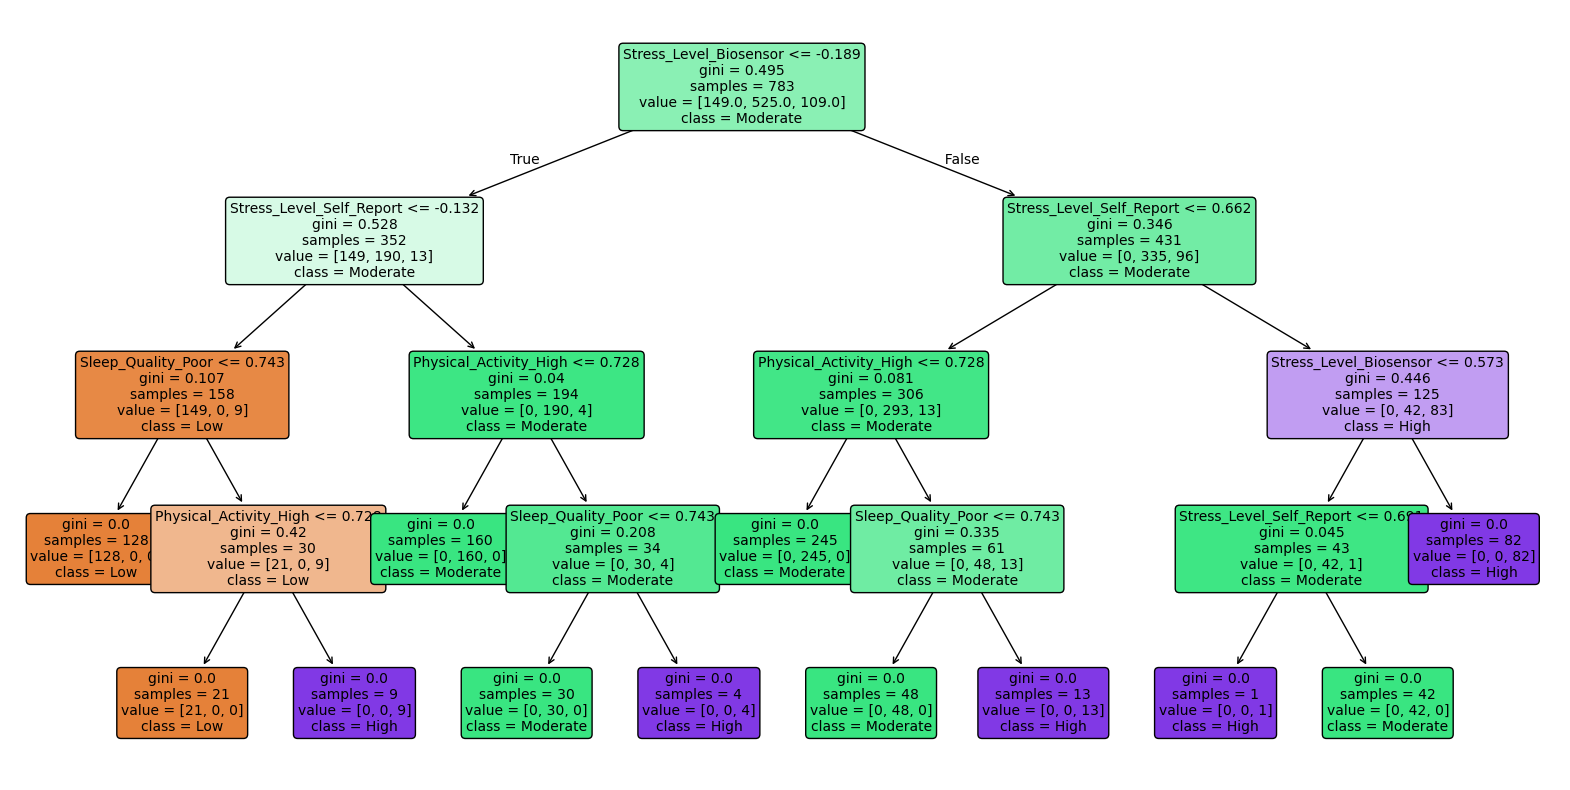

In [74]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt, 
          feature_names=X_train_subset.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

In [75]:
print("Depth of the decision tree: ", dt.tree_.max_depth)#depth of tree
print("Number of nodes: ", dt.tree_.node_count) #number of nodes
print("Number of splits: ", dt.tree_.n_leaves) #number of splits

Depth of the decision tree:  4
Number of nodes:  23
Number of splits:  12


In [76]:
#get feature importanc scores
feature_importance = dt.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt = importance_dt.sort_values(by='Importance', ascending=False)

#display top features
importance_dt

,Feature,Importance
0,Stress_Level_Self_Report,0.597734
1,Stress_Level_Biosensor,0.273982
2,Sleep_Quality_Poor,0.082312
3,Physical_Activity_High,0.045973


Notes:
- The initial metrics, including the CV scores are the same as before.
- The tree is the same from the tuned decision tree we did above.
- These results are expected since all other features had 0% importance.

### Tune DT

In [77]:
#define parameter grid
params = {
    'max_depth': [2, 3, 4, 5, 6], #max depth of tree
    'min_samples_split': [2, 5, 10, 20], #values to control the number of splits
    'min_samples_leaf': [1, 5, 10, 20], #values to control minimum samples oer leaf node
    'criterion': ['gini', 'entropy'] #different splitting criteria
}

#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#initialize grid search
grid_search = GridSearchCV(estimator = dt, param_grid = params, cv = 10, scoring = 'f1_weighted')

In [78]:
grid_search.fit(X_train3, y_train2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=13),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_weighted')

In [79]:
#get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [80]:
#define tuned model
dt_tune = grid_search.best_estimator_

#train the model
dt_tune.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = dt_tune.predict(X_val3)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(dt_tune, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Decision Tree (Tuned) Validation Accuracy: 0.97
Decision Tree (Tuned) Weighted F1-Score: 0.97
Decision Tree (Tuned) Weighted Precision: 0.97
Decision Tree (Tuned) Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12
Cross-Validation Accuracy: 1.00 (+/- 0.01)


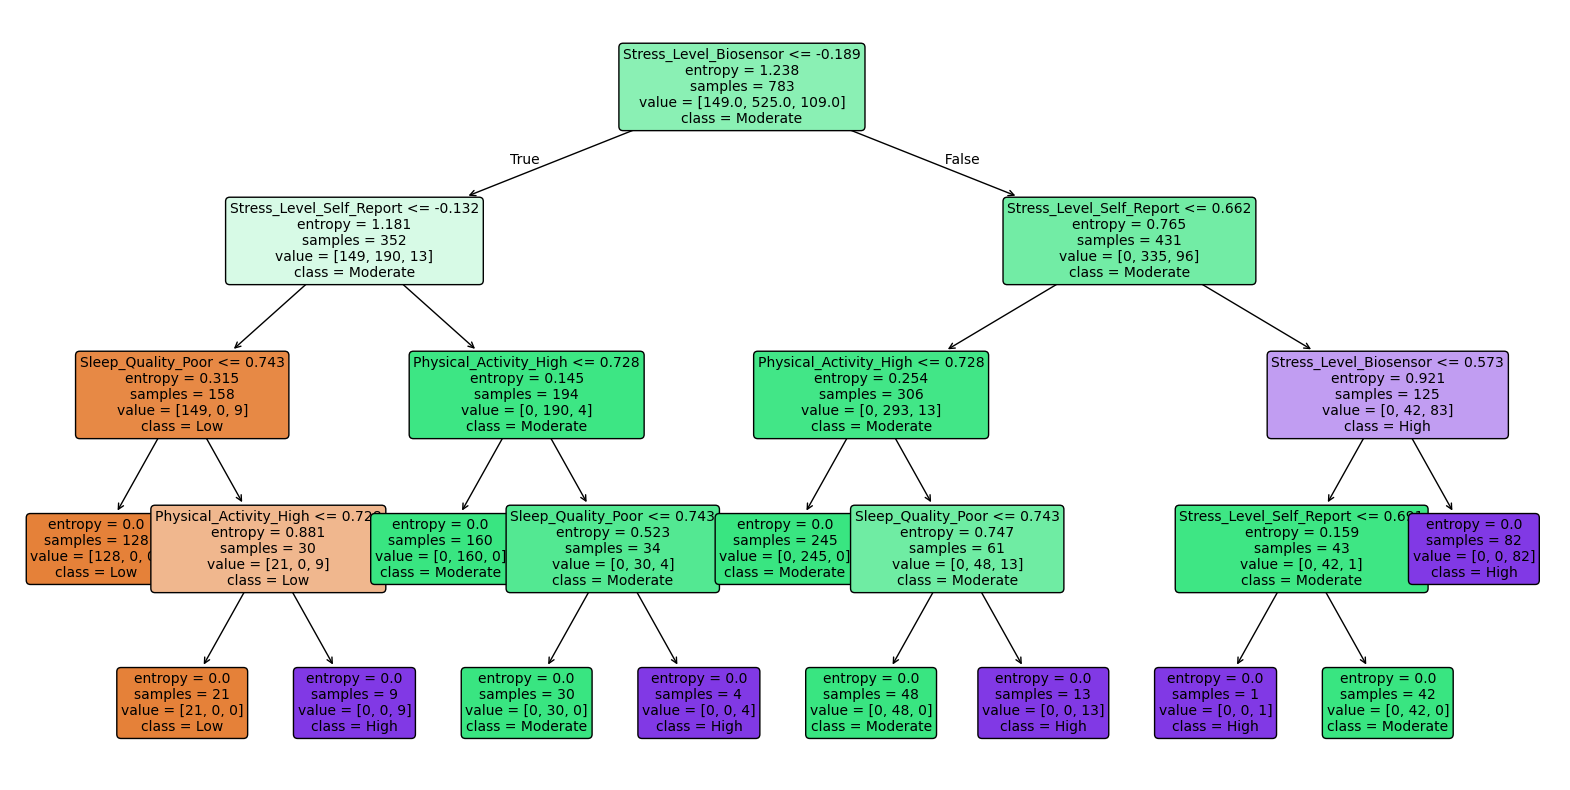

In [81]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt_tune, 
          feature_names=X_train_subset.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

In [82]:
#get feature importanc scores
feature_importance = dt_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt_tune = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt_tune = importance_dt_tune.sort_values(by='Importance', ascending=False)

#display top features
importance_dt_tune

,Feature,Importance
0,Stress_Level_Self_Report,0.496835
1,Stress_Level_Biosensor,0.342758
2,Sleep_Quality_Poor,0.089460
3,Physical_Activity_High,0.070946


In [83]:
#final test

#make predictions on test set
y_pred = dt_tune.predict(X_test3)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree (Tuned) Test Accuracy: 1.00
Decision Tree (Tuned) Weighted F1-Score: 1.00
Decision Tree (Tuned) Weighted Precision: 1.00
Decision Tree (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


Notes:
- Again, we don't see much dofference. Since all other features had 0% importance, cutting them out for the deicsion tree would only make the tree less complicated, not have any strong adjustment to the performance.

## Random Forest

### Initial RF

In [84]:
#initialize random forest
rf = RandomForestClassifier(random_state=13)

#train the model
rf.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = rf.predict(X_val3)

#evaluate random forest
rf_acc = accuracy_score(y_val2, y_pred)
rf_f1 = f1_score(y_val2, y_pred, average='weighted')
rf_precision = precision_score(y_val2, y_pred, average='weighted')
rf_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

#print metrics
print(f'Random Forest Validation Accuracy: {rf_acc:.2f}')
print(f'Random Forest Weighted F1-Score: {rf_f1:.2f}')
print(f'Random Forest Weighted Precision: {rf_precision:.2f}')
print(f'Random Forest Weighted Recall: {rf_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(rf, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Random Forest Validation Accuracy: 0.98
Random Forest Weighted F1-Score: 0.98
Random Forest Weighted Precision: 0.98
Random Forest Weighted Recall: 0.98
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   2  12
Cross-Validation Accuracy: 1.00 (+/- 0.01)


In [85]:
#get feature importanc scores
feature_importance = rf.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

#display top features
importance_rf

,Feature,Importance
0,Stress_Level_Self_Report,0.450132
1,Stress_Level_Biosensor,0.442782
2,Sleep_Quality_Poor,0.056904
3,Physical_Activity_High,0.050182


Notes:
- The only notable difference is that the average CV accuracy is higher and the standard deviation is lower. This indicates that the model consistently performs well and is stable across all folds. Thus, the model should generalize well.

### Tune RF

In [86]:
#define parameter grid
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

#initialize random forest
rf = RandomForestClassifier(random_state = 56)

#initialize grid search
grid_search = GridSearchCV(estimator = rf, param_grid = params, cv=10, n_jobs=-1, verbose=2, scoring = 'f1_weighted')

In [87]:
#fit the grid search
grid_search.fit(X_train3, y_train2)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=56),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_weighted', verbose=2)

In [88]:
#get best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [89]:
#get best model from grid search
rf_tune = grid_search.best_estimator_

#train the tuned model
rf_tune.fit(X_train3, y_train2)

#make predictions
y_pred = rf_tune.predict(X_val3)

#evaluate model 
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(rf_tune, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Random Forest (Tuned) Validation Accuracy: 0.99
Random Forest (Tuned) Weighted F1-Score: 0.99
Random Forest (Tuned) Weighted Precision: 0.99
Random Forest (Tuned) Weighted Recall: 0.99
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   1  13
Cross-Validation Accuracy: 1.00 (+/- 0.01)


In [90]:
#get feature importance scores
feature_importance = rf_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf_tune = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf_tune = importance_rf_tune.sort_values(by='Importance', ascending=False)

#display top features
importance_rf_tune

,Feature,Importance
0,Stress_Level_Self_Report,0.443946
1,Stress_Level_Biosensor,0.425898
2,Sleep_Quality_Poor,0.069474
3,Physical_Activity_High,0.060683


In [91]:
#make predictions on test set
y_pred = rf_tune.predict(X_test3)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest (Tuned) Test Accuracy: 1.00
Random Forest (Tuned) Weighted F1-Score: 1.00
Random Forest (Tuned) Weighted Precision: 1.00
Random Forest (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


Notes:
- Grid search took a lot less time, likely due to the smaller dataset.
- The evaluation metrics are the same.
- The CV scores here are slightly better than the original tuned random forest. The accuracy is higher and the standard deviation is lower.
- No change in the final test performance.

## XGBoost

In [92]:
#initialize xgboost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=13)

#train the model
xgb.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = xgb.predict(X_val3)

#evaluate XGBoost
xgb_acc = accuracy_score(y_val2, y_pred)
xgb_f1 = f1_score(y_val2, y_pred, average='weighted')
xgb_precision = precision_score(y_val2, y_pred, average='weighted')
xgb_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(xgb, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   0  14
Cross-Validation Accuracy: 1.00 (+/- 0.01)


In [93]:
#get feature importanc scores
feature_importance = xgb.feature_importances_

#create dataframe to visualize feature importance scores
importance_xgb = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)

#display top features
importance_xgb

,Feature,Importance
0,Stress_Level_Self_Report,0.393750
1,Stress_Level_Biosensor,0.316934
2,Sleep_Quality_Poor,0.168043
3,Physical_Activity_High,0.121274


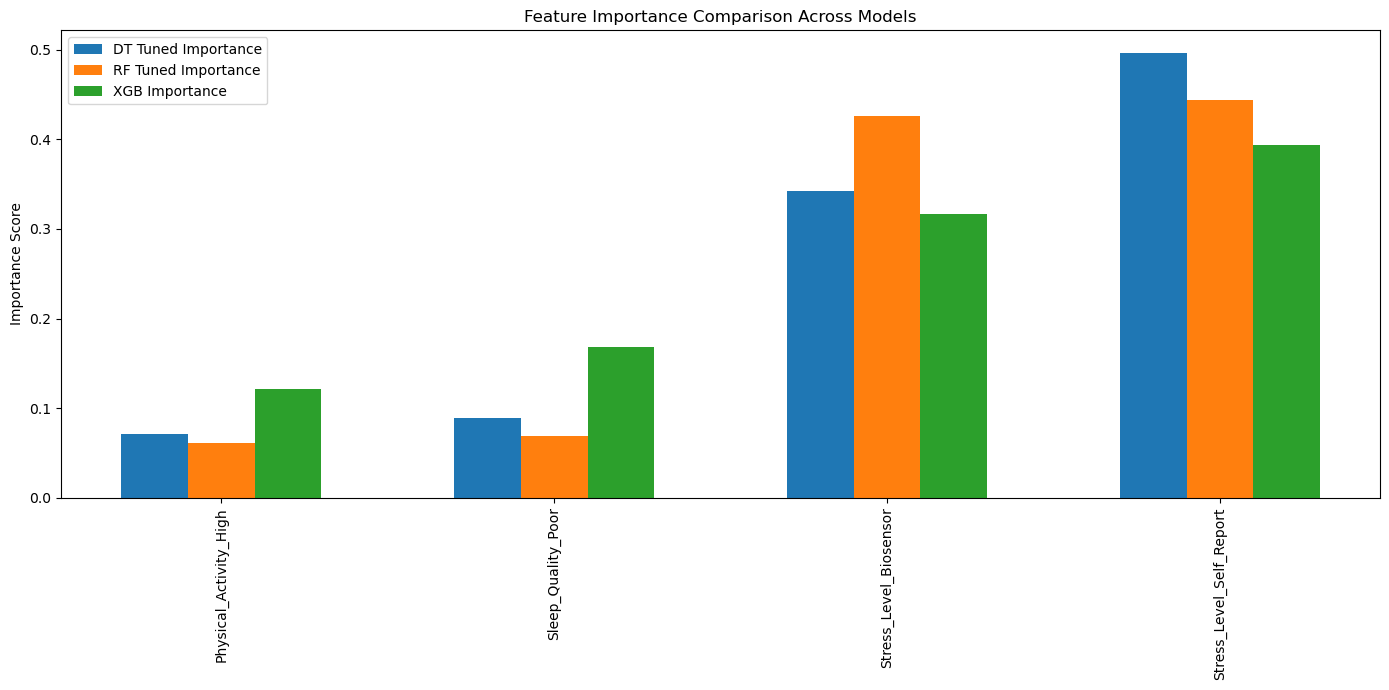

In [94]:
#ensure feature columns are the same
importance_dt_tune = importance_dt_tune.sort_values(by='Feature').reset_index(drop=True)
importance_rf_tune = importance_rf_tune.sort_values(by='Feature').reset_index(drop=True)
importance_xgb = importance_xgb.sort_values(by='Feature').reset_index(drop=True)

#merge on feature column
df_compare = importance_dt_tune.merge(importance_rf_tune, on='Feature', suffixes=('_dt_tune', '_rf_tune'))
df_compare = df_compare.merge(importance_xgb, on='Feature')
df_compare.rename(columns={'Importance': 'Importance_xgb'}, inplace=True)

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.2  #width of the bars

#plot importance for Tuned Decision Tree
ax.bar(df_compare.index - width, df_compare['Importance_dt_tune'], width, label='DT Tuned Importance')

#plot importance for Tuned Random Forest
ax.bar(df_compare.index, df_compare['Importance_rf_tune'], width, label='RF Tuned Importance')

# plot importance for XGBoost
ax.bar(df_compare.index + width, df_compare['Importance_xgb'], width, label='XGB Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance Score')
ax.set_title('Feature Importance Comparison Across Models')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

In [95]:
#make predictions on validation set
y_pred = xgb.predict(X_test3)

#evaluate XGBoost
xgb_acc = accuracy_score(y_test2, y_pred)
xgb_f1 = f1_score(y_test2, y_pred, average='weighted')
xgb_precision = precision_score(y_test2, y_pred, average='weighted')
xgb_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


Notes:
- No changes in evaluation metrics.